In [77]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import fit_functions as ff

In [78]:
path = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\U shaped measurements\Measurements_2024-02-16\10-03-34single_measurement_PD background noise,\ESA_spectrum_PD background"
path_spectrum = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\U shaped measurements\Measurements_2024-02-16\2024-02-16_11-28-07single_measurement_EOM_on_80MHz\2024-02-16_11-28-07_ESA_full_spectrum_, EOM on at 80 MHz, ,feedback_None"
path_bg = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\U shaped measurements\Measurements_2024-02-16\2024-02-16_11-29-30single_measurement_EOM_off\2024-02-16_11-29-30_ESA_full_spectrum_, EOM off,feedback_None"



peak1 = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\U shaped measurements\2024-02-16_16-43-56single_measurement_EOM_on_80MHz\2024-02-16_16-43-56_ESA_peak_spectrum_, EOM on at 80 MHz, ,feedback_-57.08 dB.txt"
peak1_bg = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\U shaped measurements\2024-02-16_16-43-56single_measurement_EOM_on_80MHz\2024-02-16_16-43-56_ESA_peak_spectrum_, EOM off,feedback_-57.08 dB.txt"

directory = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\U shaped measurements\2024-02-16_16-43-56single_measurement_EOM_on_80MHz"
directory2 = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\Measurements_2024-02-18\2024-02-18_13-07-30single_measurement_"
directory3 = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\Measurements_2024-02-18\2024-02-18_15-15-26single_measurement_"
directory4 =  r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\Measurements_2024-02-18\2024-02-18_14-05-29single_measurement_"
directory5 = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\Measurements_2024-02-18\2024-02-18_14-43-40single_measurement_"
directory6 = r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\Measurements_2024-02-18\2024-02-18_15-02-33single_measurement_"

def get_esa_data(path):
    #Returns:
    #freqs: frequency axis in MHz
    #powers: ESA power in dBm 
    data = np.loadtxt(path)
    freqs = data[0,:]*1e-6
    powers = data[1,:]
    return freqs, powers

def plot_spectrum(freqs,powers,label=''):
    plt.plot(freqs,powers,label=label)
    plt.xlabel('Fourier frequency [MHz]')
    plt.ylabel('ESA power [dBm]')


def subtract_background(path_spectrum,path_bg,k=1):
    freqs, powers = get_esa_data(path_spectrum)
    freqs_bg, powers_bg = get_esa_data(path_bg)

    powers_lin = 10**(powers/10)
    powers_bg_lin = 10**(powers_bg/10)

    powers_difference_lin = abs(powers_lin - k*powers_bg_lin)
    powers_difference = 10*np.log10(powers_difference_lin)
    return freqs, powers_difference

def get_subtracted_background(signal,background,k=1, plot=False, center_about_carrier = False):
    freqs, powers = get_esa_data(signal)
    freqs_new, powers_new = subtract_background(signal,background,k)
    if plot:
        plot_spectrum(freqs,powers,label='Raw')
        plot_spectrum(freqs_new,powers_new,label='Background subtracted')
        plt.legend()
    if center_about_carrier:
        freqs_new = freqs_new - 80
        powers_new = powers_new - max(powers_new)
    return freqs_new, powers_new

def gauss_log(x,a,b):
    return -0.5*(x/a)**2 + b


def lor_log(x,a,df):
    return a + 10*np.log10(df/(df**2 + x**2))

def get_data_from_folder(directory):
    files = os.listdir(directory)
    def path(file):
        return directory + '\\' + file
    return ([path(files[1]), path(files[3])], [path(files[5]), path(files[7])], [path(files[8])])

def get_full_spectrum_from_folder(directory,k=1):
    esa_full, esa_close, osa = get_data_from_folder(directory)
    fs, ps = get_subtracted_background(esa_full[1], esa_full[0],k)
    return fs, ps

def get_close_spectrum_from_folder(directory,k=1):
    esa_full, esa_close, osa = get_data_from_folder(directory)
    fs, ps = get_subtracted_background(esa_close[1], esa_close[0],k)
    return fs, ps

def fit_profile(fs, ps, threshold_close, threshold_mid, threshold_far):
    
    filter_close = abs(fs) < threshold_close
    filter_far = (abs(fs) > threshold_mid) &  (abs(fs) < threshold_far)

    fs_close = fs[filter_close]
    ps_close = ps[filter_close]
    fs_far = fs[filter_far]
    ps_far = ps[filter_far]

    plt.plot(fs,ps)
    params_close,_ = curve_fit(gauss_log,fs_close,ps_close)
    params_far,_ = curve_fit(lor_log,fs_far,ps_far)
    fwhm1 = abs(2*params_close[0])*2*np.sqrt(2*np.log(2))
    fwhm2 = 2*abs(params_far[1])

    plt.plot(fs,gauss_log(fs,*params_close),label = 'Gaussian fit')
    plt.plot(fs,lor_log(fs,*params_far),label= 'Lorentzian fit')
    

    plt.xlim([-4,4])
    plt.ylim([-40,5])
    plt.ylabel('DSH power [dBc]')
    plt.xlabel('Carrier detuning [MHz]')
    plt.legend()
    return fwhm1,fwhm2

def fit_profile_from_folder(directory, threshold_close, threshold_mid, threshold_far):
    esa_full, esa_close, osa = get_data_from_folder(directory)
    fs, ps = get_subtracted_background(esa_close[1], esa_close[0],plot=False, center_about_carrier=True)
    fwhm1, fwhm2 = fit_profile(fs, ps, threshold_close, threshold_mid, threshold_far)
    return fwhm1, fwhm2 


In [79]:
get_close_spectrum_from_folder(directory6,k=1)

(array([75.    , 75.0001, 75.0002, ..., 84.9997, 84.9998, 84.9999]),
 array([-111.91355999, -110.39269352, -110.0740976 , ..., -108.52235842,
        -106.44161112, -105.1007395 ]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


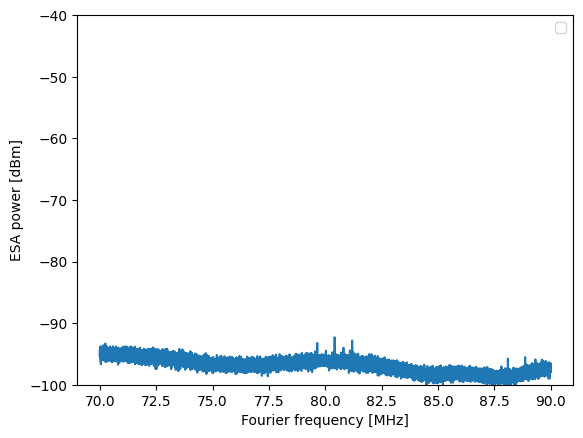

In [80]:
fs, ps = get_subtracted_background(peak1,peak1_bg,k=1)
fs_bg, ps_bg = get_esa_data(peak1_bg)
plot_spectrum(fs_bg, ps_bg)
fs = fs - 80
ps = ps - max(ps)
plt.ylim([-100,-40])
plt.legend()


(0.3833981222669882, 0.3649620310206138)

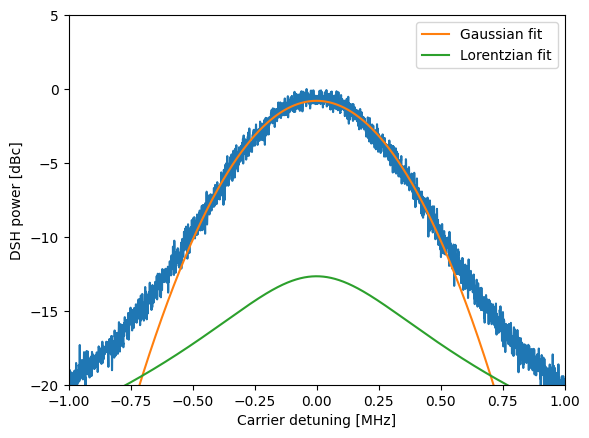

In [81]:
#fs, ps = get_close_spectrum_from_folder(directory)
gauss_fwhm, lor_fwhm = fit_profile(fs,ps,.5,2,3)
plt.xlim([-1,1])
plt.ylim([-20,5])
gauss_fwhm/np.sqrt(2), lor_fwhm/2

(0.3833981222669882, 0.3649620310206138)

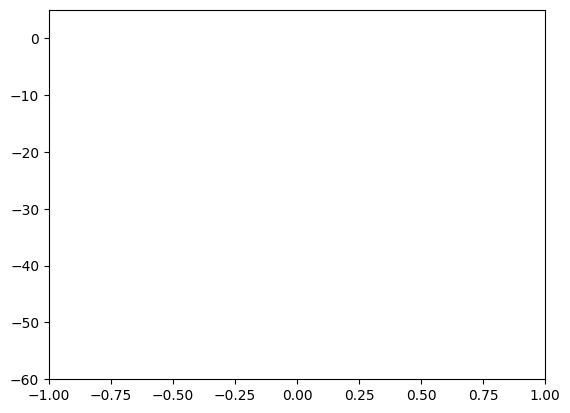

In [82]:
#gauss_fwhm, lor_fwhm = fit_profile_from_folder(directory3,1,.4,.8)
plt.xlim([-1,1])
plt.ylim([-60,5])
gauss_fwhm/np.sqrt(2), lor_fwhm/2

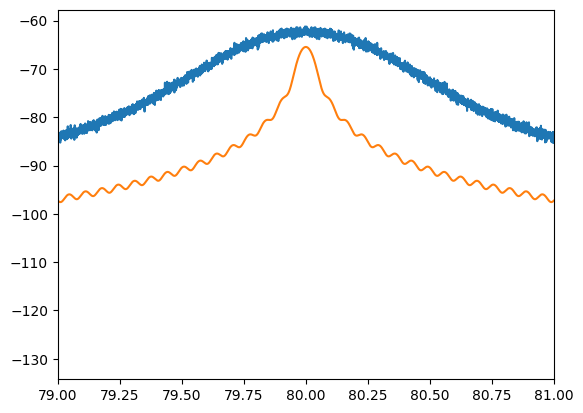

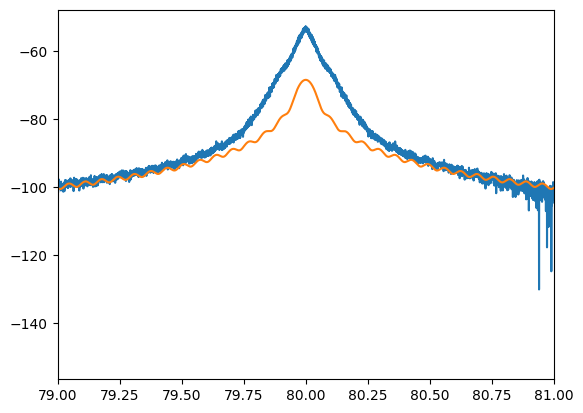

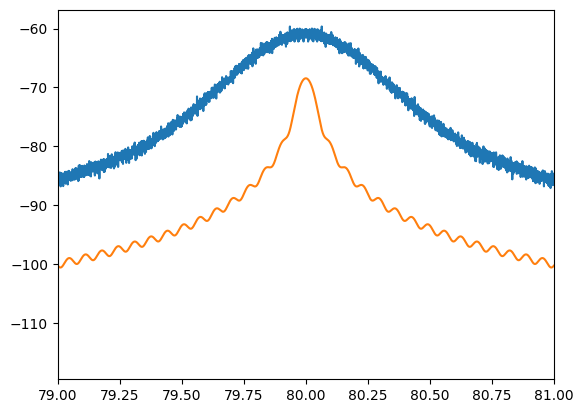

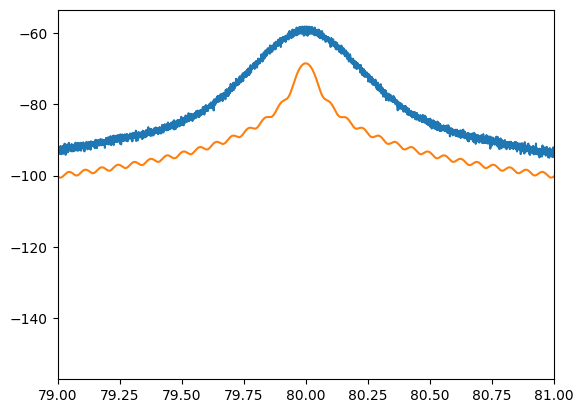

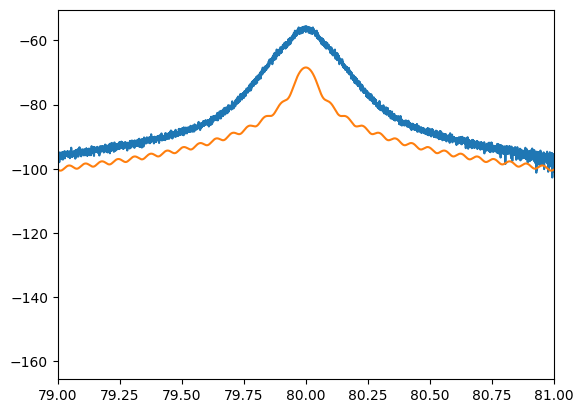

In [86]:
plt.close("all")


offset = [-12,-15,-15,-15,-15,-15]

for i in range(2,7):
    fs, ps = get_close_spectrum_from_folder(globals()[f'directory{i}'])

    #gauss_fwhm, lor_fwhm = fit_profile(fs,ps,.5,2,3)

    #gauss_fwhm/np.sqrt(2), lor_fwhm/2


    plt.figure(i-2)
    plt.plot(fs,ps)

    plt.plot(fs,10*np.log10(ff.zeta_func((fs-80)*1e6,2*10**4,t_d))+offset[i-2],'-')

    plt.xlim([79,81])
    #plt.ylim([-20,5])

In [92]:
testdata = np.loadtxt(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\U shaped measurements\Measurements_2024-02-16\2024-02-16_12-01-16single_measurement_EOM_on_80MHz\ESA_spectrum_EOM on 80MHz, with feedback")

c:\Users\au617810\OneDrive - Aarhus universitet\Videnskabelig assistent\PICLab-narrow-linewidth\feedback-u-shaped-laser\fit_functions.py:46: RuntimeWarning: divide by zero encountered in divide
  return del_o(del_f) * ( 1-math.exp(-t_d*del_o(del_f)) * (np.cos(Omega*t_d) + del_o(del_f)/Omega * np.sin(Omega*t_d)) ) / ( del_o(del_f)**2 + Omega**2)
c:\Users\au617810\OneDrive - Aarhus universitet\Videnskabelig assistent\PICLab-narrow-linewidth\feedback-u-shaped-laser\fit_functions.py:46: RuntimeWarning: invalid value encountered in multiply
  return del_o(del_f) * ( 1-math.exp(-t_d*del_o(del_f)) * (np.cos(Omega*t_d) + del_o(del_f)/Omega * np.sin(Omega*t_d)) ) / ( del_o(del_f)**2 + Omega**2)


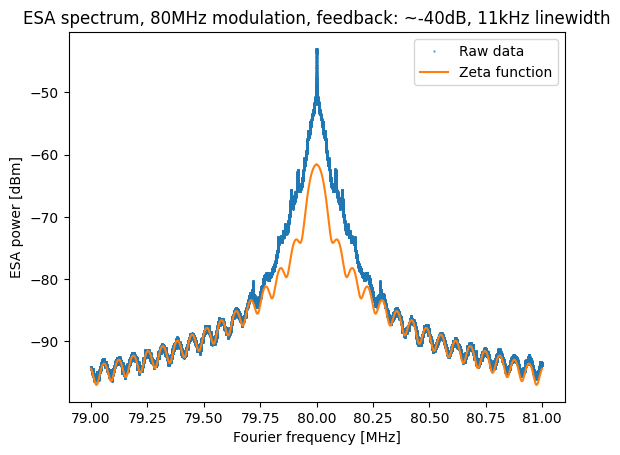

In [167]:
t_d = ff.time_delay(3140)

plt.figure(10)
plt.plot(testdata[0]*1e-6,testdata[1],'.',markersize=0.91)
plt.plot(testdata[0]*1e-6,10*np.log10(ff.zeta_func((testdata[0]*1e-6-80)*1e6,1.1*10**4,t_d))-7.8,'-')
plt.xlabel('Fourier frequency [MHz]')
plt.ylabel('ESA power [dBm]')
plt.title('ESA spectrum, 80MHz modulation, feedback: ~-40dB, 11kHz linewidth')
plt.legend(['Raw data','Zeta function'])


plt.savefig(r"..\..\Narrow_linewidth_lasers repository\Slides\Fit_of_zeta_func.png")
